# Analyse textuelle

> Ces données sont aussi l'occasion de faire du Text Mining et de l'analyse de sentiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json
import networkx as nx

In [2]:

df = pd.read_csv('text_data.csv')
df.head()

,user_id_str,timestamp_ms,text
0,-2093509345620286912,1.643323e+12,"RT @NicolasPichot6: 🔴Macron, Fillon : ce que r..."
1,-3727171127289534268,1.643355e+12,Y a que Sarkozy qui connait la réponse
2,-3218205128951880001,1.643357e+12,RT @alma_dufour: Ah tiens le site de campagne ...
3,6553976399885616064,1.643322e+12,"Quel guignol ce Mélenchon. Lui président, la F..."
4,6650649686239584458,1.643355e+12,@_Pat_Sim_ @BQuestel Macron en campagne sans c...


## Analyse de sentiments

> L'analyse de sentiment consiste à mesurer si un texte exprime un sentiment négatif ou positif. Dans cet exemple, nous allons utiliser la librairie VaderSentimentFR qui nous permet facilement d'évaluer un score de positivité (compris entre -1 et 1) en faisant la moyenne des différents scores des mots d'une phrase. Il faut garder à lesprit que c'est un modèle trop simple pour réellement trouver des tendances.

In [3]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

sentiment_intensity_analyzer = SentimentIntensityAnalyzer()

/home/paul/.local/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
sentiment_intensity_analyzer.polarity_scores('La vie est belle')

{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'compound': 0.1779}

In [5]:
sentiment_intensity_analyzer.polarity_scores('La vie est pas belle')

{'neg': 0.275, 'neu': 0.725, 'pos': 0.0, 'compound': -0.1326}

In [6]:
sentiment_intensity_analyzer.polarity_scores('La vie est moche')

{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'compound': -0.5106}

In [7]:
df['scores'] = df['text'].apply(lambda x: sentiment_intensity_analyzer.polarity_scores(x)['compound'])

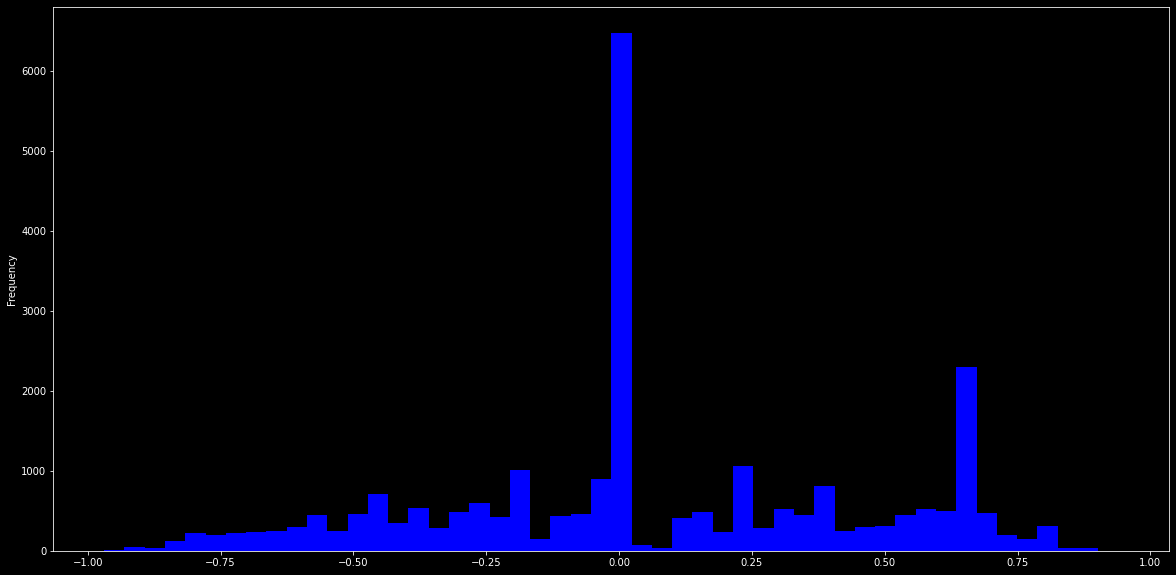

In [8]:
with plt.style.context('dark_background'):
    df['scores'].plot.hist(bins=50, figsize=(20, 10), color='b')
    plt.show()

In [9]:
df['scores'].describe([i/10 for i in range(10)])

count    25812.000000
mean         0.059444
std          0.407128
min         -0.969500
0%          -0.969500
10%         -0.492600
20%         -0.290500
30%         -0.100700
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.271400
80%          0.491200
90%          0.669600
max          0.940100
Name: scores, dtype: float64

> On remarque un grand pic autour de 0. En moyenne les scores sont neutres même si on retrouve des valeurs extrèmes. Pour mieux voir ce qu'il se dit, on peut essayer de dédoublonner les valeurs: 

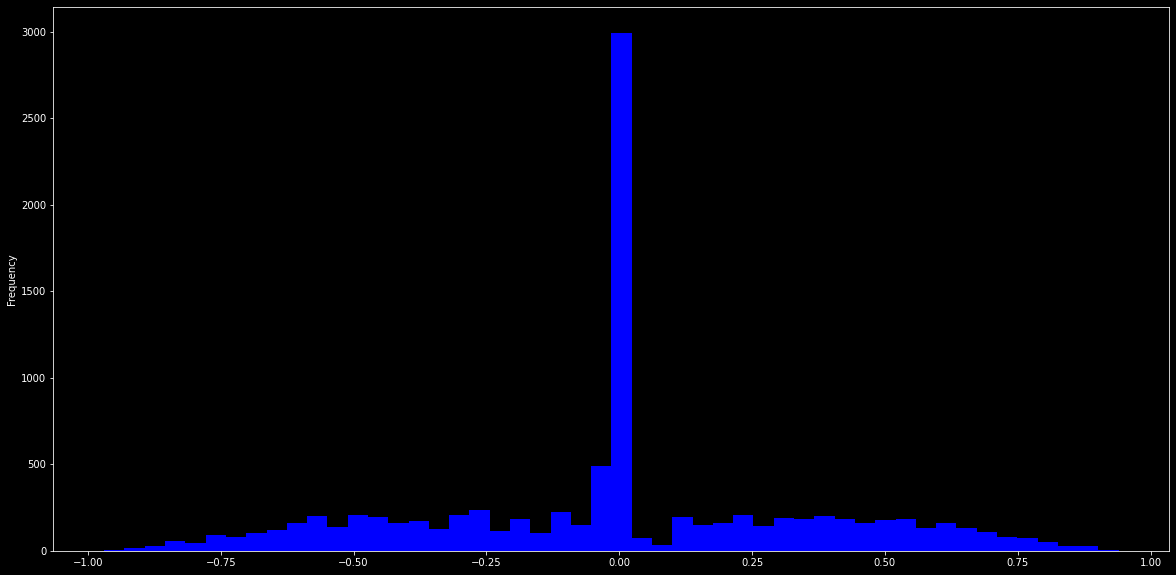

In [10]:
temp_df = df[['scores', 'text']].drop_duplicates()

with plt.style.context('dark_background'):
    temp_df['scores'].plot.hist(bins=50, figsize=(20, 10), color='b')
    plt.show()

> On remarque une chute nette vers 0.65.
>
> On peut aussi suivre l'évolution du score au fil du temps

In [11]:
df['datetime'] = pd.to_datetime(df['timestamp_ms'], unit='ms')

time_analysis = df[['datetime', 'scores']].copy()


time_analysis['year'] = time_analysis['datetime'].dt.year
time_analysis['month'] = time_analysis['datetime'].dt.month
time_analysis['day'] = time_analysis['datetime'].dt.day

time_analysis['hour'] = time_analysis['datetime'].dt.hour
time_analysis['minute'] = time_analysis['datetime'].dt.minute

time_analysis = time_analysis.groupby(['year', 'month', 'day', 'hour', 'minute']).mean().reset_index()

time_analysis['datetime'] = pd.to_datetime(time_analysis[['year', 'month', 'day', 'hour', 'minute']])

time_analysis.head()

,year,month,day,hour,minute,scores,datetime
0,2022,1,27,21,48,0.130257,2022-01-27 21:48:00
1,2022,1,27,21,54,-0.129062,2022-01-27 21:54:00
2,2022,1,27,21,55,0.044957,2022-01-27 21:55:00
3,2022,1,27,21,56,0.022425,2022-01-27 21:56:00
4,2022,1,27,21,57,0.032227,2022-01-27 21:57:00


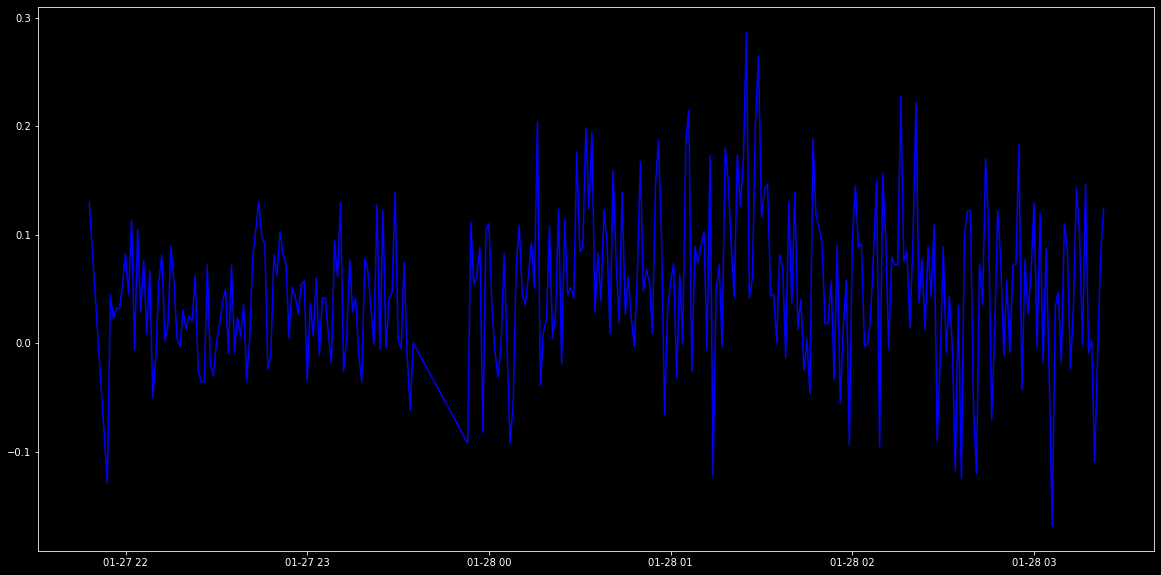

In [12]:
time_limit = pd.to_datetime('28/01/2022 4:00:00')


with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 10))
    plt.plot(
        time_analysis['datetime'][time_analysis['datetime'] < time_limit],
        time_analysis['scores'][time_analysis['datetime'] < time_limit],
        color='b')
    plt.show()

> On ne trouve rien de clair.

## Analyse des mots

> On va étudier quels sont les mots les plus utilisés. Pour cela, il nous fait tokenizer le texte.

In [13]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

tokenizer.tokenize('La vie est belle')

['La', 'vie', 'est', 'belle']

> On doit ensuite concaténer le texte de tous les tweets.

In [14]:
text  = ' '.join(df['text'].str.lower())

mots = tokenizer.tokenize(text)

In [15]:
len(mots)

588699

> On peut ensuite utiliser la classe `Counter` de la librairie native `collections`.

In [16]:
from collections import Counter

word_count = pd.Series(Counter(mots))

word_count.sort_values(ascending=False).head(10)

:         22335
rt        19356
de        17276
…         16075
,         15100
macron    13027
le         9799
.          9291
la         8766
et         8694
dtype: int64

> De manière peu étonnante, on retrouve principalement des stop words. C'est à dire des mots sans grand intérêt. On va retirer ces mots

In [17]:
from nltk.corpus import stopwords

sw = set(stopwords.words('french'))



In [18]:
from nltk.corpus import stopwords

sw = set(stopwords.words('french'))

sw.update({':', 'rt', '…', ',', ';', '!', 'a', '.', ',', '"', '?'})

word_count = pd.Series(Counter([m for m in mots if m not in sw]))
word_count.sort_values(ascending=False).head(10)

macron     13027
’           7594
fait        3101
veut        2366
poutine     2275
s'est       2116
mdr         2050
#macron     2039
menacer     2009
gifler      2005
dtype: int64

> On peut aussi essayer de faire la même chose avec les emojis :) 

In [19]:
emojis = sentiment_intensity_analyzer.emojis.keys()
list(emojis)[:100]

['😀',
 '😃',
 '😄',
 '😁',
 '😆',
 '😅',
 '🤣',
 '😂',
 '🙂',
 '🙃',
 '😉',
 '😊',
 '😇',
 '🥰',
 '😍',
 '🤩',
 '😘',
 '😗',
 '☺️',
 '😚',
 '😙',
 '\U0001f972',
 '😋',
 '😛',
 '😜',
 '🤪',
 '😝',
 '🤑',
 '🤗',
 '🤭',
 '🤫',
 '🤔',
 '🤐',
 '🤨',
 '😐',
 '😑',
 '😶',
 '😏',
 '😒',
 '🙄',
 '😬',
 '🤥',
 '😌',
 '😔',
 '😪',
 '🤤',
 '😴',
 '😷',
 '🤒',
 '🤕',
 '🤢',
 '🤮',
 '🤧',
 '🥵',
 '🥶',
 '🥴',
 '😵',
 '🤯',
 '🤠',
 '🥳',
 '\U0001f978',
 '😎',
 '🤓',
 '🧐',
 '😕',
 '😟',
 '🙁',
 '☹️',
 '😮',
 '😯',
 '😲',
 '😳',
 '🥺',
 '😦',
 '😧',
 '😨',
 '😰',
 '😥',
 '😢',
 '😭',
 '😱',
 '😖',
 '😣',
 '😞',
 '😓',
 '😩',
 '😫',
 '🥱',
 '😤',
 '😡',
 '😠',
 '🤬',
 '😈',
 '👿',
 '💀',
 '☠️',
 '💩',
 '🤡',
 '👹',
 '👺']

In [20]:
import re

# solution trouvée ici: https://stackoverflow.com/a/46037591/8750662 pour éviter le bug du live
regex = re.compile(r"(?<!\w)(?:{})(?!\w)".format('|'.join([re.escape(x) for x in emojis])))

retrieved_emojis = re.findall(pattern=regex, string=text)


emojis_count = pd.Series(Counter(retrieved_emojis)).sort_values(ascending=False)

emojis_count.head(20)

👏     1377
😂      333
💪      294
🔴      257
🤣      248
⚡      244
📢      199
📹      186
😯      180
🇫🇷     174
😡      147
▶️     109
🤮       75
🚨       72
😳       72
👍       70
‼️      68
🤔       67
🇨🇵      63
😅       54
dtype: int64

> Cette analyse est très courte et mériterait qu'on s'y attache plus avant. 